---
# Intertrial Variability: 2. Data Analysis

In [7]:
import sys; sys.path.insert(1, '../')

from functools import partial
import numpy as np
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font_scale=1.,style='ticks',context='notebook',font= 'georgia')
from scipy.stats import ttest_ind
import pingouin
from scripts.preproc import *
from scripts.viz import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [2]:
fn = '../processed/data_preprocessed.pkl'

with open(fn, 'rb') as f:
    [all_data_raw, all_data_epoch] = pkl.load(f)
# Load AQ and EQ data
fn = 'D:/data/Psychiatrie_Autismus_2012/AQ_EQ.json'

AQ, EQ = get_AQ_EQ(fn, all_data_epoch)

# Convert Dict to list cause thats how i like it
all_data_epoch = [list(all_data_epoch['control'].values()), list(all_data_epoch['asd'].values())]
info = all_data_epoch[0][0].info
times = all_data_epoch[0][0].times
ch_names = all_data_epoch[0][0].ch_names

# ITV

## Compute

In [5]:
ch_picks = ['O1', 'Oz', 'O2']
ch_indices = [ch_names.index(ch) for ch in ch_picks]
conds = [['SF', 'LF'], ['GPL', 'GPS']]
cond_labels = ['Frequent checkers',  'Grey blanks']

time_range = [-0.2, 0.5]
pnt_range = np.arange(*[np.argmin(np.abs(times-t)) for t in time_range])
scaler = 1e6

itv_conds = [[np.stack(list(map(partial(calc_itv, cond=cond, norm_type=None, relative=False), epochs)), axis=0) 
            for epochs in all_data_epoch] 
            for cond in conds]


## Plot

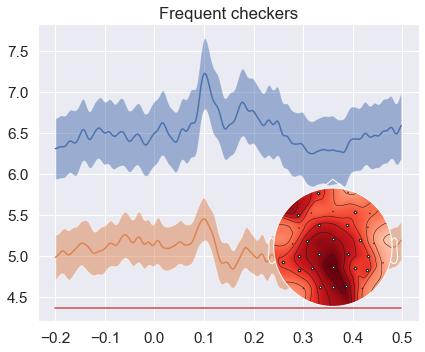

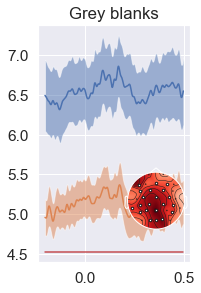

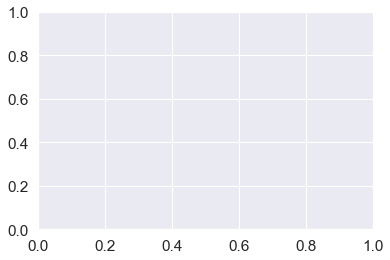

In [10]:
figsize = (15, 5)
fig = plt.figure(num='ITV', figsize=figsize)
sns.set(font_scale=1.4)
for i, (cond, itv) in enumerate(zip(conds, itv_conds)):
    itv = [scaler * x[:, :, pnt_range] for x in itv]
    N = 121+i
    ax = plt.subplot(N)
    plot_itv(itv, times[pnt_range], ax, info, cond=cond, title=cond_labels[i], alpha=0.05, ch_picks=ch_picks)
    ax.set_ylim((0, plt.ylim()[1]))
    if i == 0:
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('ITV [\u03BCV]')
    
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout()

# multipage(r'C:\Users\Lukas\Documents\VariabilityAnalysis\figures\paper\for_review\ITV.pdf', figs=[fig], dpi=300, png=True)

## Prepare Data Frame

In [16]:
ch_picks = ['O1', 'Oz', 'O2']
ch_indices = [ch_names.index(ch) for ch in ch_picks]
conds = [['SF', 'LF'], ['GPL', 'GPS']]
cond_labels = ['Frequent checkers',  'Grey blanks']


# Subject List
subjects = np.concatenate([
    ['Control_'+str(i+1) for i in range(len(all_data_epoch[0]))], 
    ['ASD_'+str(i+1) for i in range(len(all_data_epoch[1]))]
    ])
groups = np.concatenate([
    ['Control' for _ in range(len(all_data_epoch[0]))], 
    ['ASD' for _ in range(len(all_data_epoch[1]))]
    ])

df_list = []
# loop through Stimuli
for i, (itv, cond, cond_label) in enumerate(zip(itv_conds, conds, cond_labels)):
    # Prepare Data of the current stimulus    
    data = np.concatenate([np.mean(itv[0][:, ch_indices, :], axis=-1), np.mean(itv[1][:, ch_indices, :], axis=-1)], axis=0)
    
    df = pd.DataFrame(data, columns=ch_picks)
    df['Subject'] = subjects
    df['Group'] = groups
    df['Stimulus'] = [cond_label] * data.shape[0]
    # Melt individual electrode columns into a single Column
    df_itv = df.melt(value_vars=ch_picks, 
                    id_vars=['Subject', 'Group', 'Stimulus'], 
                    value_name='ITV', var_name='Electrode')
    df_list.append(df_itv)
# Concatenate DataFrames of the different stimuli
df_itv = pd.concat(df_list)

## Statistics

In [17]:
dependent_variable = 'ITV'
factors = ['Group', 'Stimulus']
aov = df_itv.anova(dv=dependent_variable, between=factors, detailed=True, effsize='n2')


# post-hoc test
post_hoc = df_itv.pairwise_tukey(dv=dependent_variable, between='Group')
display(aov)
print('\nPost-Hoc:\n')
display(post_hoc)

,Source,SS,DF,MS,F,p-unc,n2
0,Group,1.087717e-10,1.0,1.087717e-10,55.127110,2.932998e-12,0.211028
1,Stimulus,1.886140e-13,1.0,1.886140e-13,0.095592,7.574969e-01,0.000366
2,Group * Stimulus,1.782020e-14,1.0,1.782020e-14,0.009032,9.243799e-01,0.000035
3,Residual,4.064599e-10,206.0,1.973106e-12,NaN,NaN,NaN



Post-Hoc:



,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,ASD,Control,0.000005,0.000007,-0.000001,1.936908e-07,-7.458825,0.001,-1.029488


# ETV

## Compute

In [19]:
ch_picks = ['O1', 'Oz', 'O2']
ch_indices = [ch_names.index(ch) for ch in ch_picks]
conds = ['SF', 'LF', 'GPL', 'GPS']
cond_labels = ['Small frequent', 'Large frequent', 'Grey screen L', 'Grey screen S']

time_range = [-0.2, 0.5]
pnt_range = [np.argmin(np.abs(times-time_range[0])), 
            np.argmin(np.abs(times-time_range[1]))]
pnt_range = np.arange(*pnt_range)

# Calc ETV
etv_conds = [[list(map(partial(calc_etv, cond=cond), epochs)) 
        for epochs in all_data_epoch] 
        for cond in conds]


## Plot

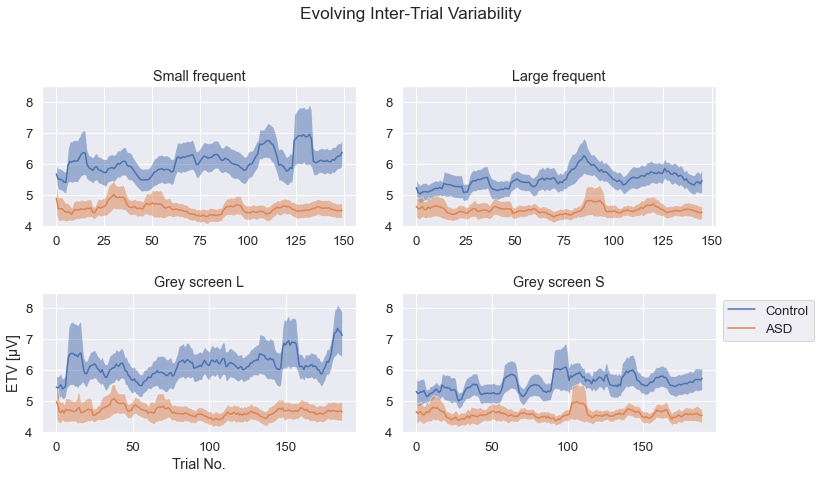

In [22]:

# ylim = (5, 8.5)
ylim = (4, 8.5)
scaler = 1e6

figsize = (12, 7)
fig = plt.figure(num='ETV', figsize=figsize)
sns.set(font_scale=1.2)
plt.suptitle('Evolving Inter-Trial Variability')
for i, (etv, cond) in enumerate(zip(etv_conds, conds)):
    params = dict(cond=cond)
    
    # Cut of trials so all participants have the same amount
    min_tr = min([min([sub.shape[0] for sub in eee]) for eee in etv])
    etv = [np.stack([sub[:min_tr, ch_indices, :]*scaler for sub in eee], axis=0) for eee in etv]
    # Average over time and re-arrange
    etv = [np.swapaxes(np.mean(group[..., pnt_range], axis=-1), 1, 2) for group in etv]
    # Plot
    N = 221+i
    ax = plt.subplot(N)
    plot_etv(etv, ax, info, cond=cond, title=cond_labels[i])
    ax.set_ylim(ylim)
    if i == 2:
        ax.set_xlabel('Trial No.')
        ax.set_ylabel('ETV [\u03BCV]')
    
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.tight_layout(pad=2)

# multipage(r'C:\Users\Lukas\Documents\VariabilityAnalysis\figures\paper\for_review\ETV.pdf', figs=[fig], dpi=300, png=True)

## Prepare Data Frame

In [23]:
conds = ['SF', 'LF',  'GPL', 'GPS']
cond_labels = ['Small frequent', 'Large frequent',  'Grey screen L', 'Grey screen S']
experiments = ['LR', 'SR', 'LR', 'SR']
etv = etv_conds[0]
# Subject List
subjects = np.concatenate([
    ['Control_'+str(i+1) for i in range(len(all_data_epoch[0]))], 
    ['ASD_'+str(i+1) for i in range(len(all_data_epoch[1]))]
    ])
groups = np.concatenate([
    ['Control' for _ in range(len(all_data_epoch[0]))], 
    ['ASD' for _ in range(len(all_data_epoch[1]))]
    ])


df_list = []
# loop through Stimuli
for i, (etv, cond, cond_label, experiment) in enumerate(zip(etv_conds, conds, cond_labels, experiments)):
    # Cut of trials so all participants have the same amount
    min_tr = min([min([sub.shape[0] for sub in eee]) for eee in etv])
    etv = [np.stack([sub[:min_tr, ch_indices, :]*1e6 for sub in eee], axis=0) for eee in etv]
    # Average over time and re-arrange
    etv = [np.swapaxes(np.mean(group[..., pnt_range], axis=-1), 1, 2) for group in etv]
    # Prepare Data of the current stimulus    
    data = np.concatenate([np.mean(etv[0], axis=-1), np.mean(etv[1], axis=-1)], axis=0)
    
    df = pd.DataFrame(data, columns=ch_picks)
    df['Subject'] = subjects
    df['Group'] = groups
    df['Stimulus'] = [cond_label] * data.shape[0]
    df['Condition'] = [experiment] * data.shape[0]
    # Melt individual electrode columns into a single Column
    df_etv= df.melt(value_vars=ch_picks, 
                    id_vars=['Subject', 'Group', 'Stimulus', 'Condition'], 
                    value_name='ETV', var_name='Electrode')
    df_list.append(df_etv)
# Concatenate DataFrames of the different stimuli
df_etv = pd.concat(df_list)
df_etv

,Subject,Group,Stimulus,Condition,Electrode,ETV
0,Control_1,Control,Small frequent,LR,O1,7.626953
1,Control_2,Control,Small frequent,LR,O1,6.691502
2,Control_3,Control,Small frequent,LR,O1,5.124604
3,Control_4,Control,Small frequent,LR,O1,6.789077
4,Control_5,Control,Small frequent,LR,O1,7.171111
...,...,...,...,...,...,...
100,ASD_15,ASD,Grey screen S,SR,O2,4.066449
101,ASD_16,ASD,Grey screen S,SR,O2,4.363032
102,ASD_17,ASD,Grey screen S,SR,O2,7.355960
103,ASD_18,ASD,Grey screen S,SR,O2,8.410053


## Statistics

In [24]:
dependent_variable = 'ETV'
factors = ['Group', 'Stimulus']
aov = df_etv.anova(dv=dependent_variable, between=factors, 
    detailed=True, effsize='n2')

# post-hoc test
ph_test = df_etv.pairwise_tukey(dv=dependent_variable, between='Group')
display(aov)
print('\nPost Hoc:\n')
display(ph_test)

,Source,SS,DF,MS,F,p-unc,n2
0,Group,160.954859,1.0,160.954859,94.360888,3.196178e-20,0.182481
1,Stimulus,10.880100,3.0,3.626700,2.126178,9.630357e-02,0.012335
2,Group * Stimulus,7.439132,3.0,2.479711,1.453747,2.266746e-01,0.008434
3,Residual,702.763647,412.0,1.705737,NaN,NaN,NaN



Post Hoc:



,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,ASD,Control,4.577819,5.820497,-1.242678,0.12865,-9.659343,0.001,-0.944439


# ETV Progression Statistics

In [25]:
from sklearn import linear_model
from scipy.signal import detrend

df_slope = pd.DataFrame(columns=['Subject', 'Group', 'Condition', 'Slope', 'ETVVar', 'ETVVar_detrended', 'Residual'])
groups = ['Control', 'ASD']
cond_labels = ['Small frequent', 'Large frequent', 'Grey screen L', 'Grey screen S']

for cond in range(len(etv_conds)):
    for group in range(len(etv_conds[cond])):
        for sub in range(len(etv_conds[cond][group])):
            subject = 'S' + str(sub)
            groupname = groups[group]
            conditionname = cond_labels[cond]
            etv_sample = np.mean(etv_conds[cond][group][sub][:, ch_indices, :], axis=(1, 2))
    	    # Normalize
            # etv_sample = (etv_sample - etv_sample.mean()) 
            etv_sample = (etv_sample / etv_sample.mean()) 
            
            etv_var = np.std(etv_sample)
            etv_var_detrended = np.std(detrend(etv_sample))
            # Get slope
            Y = etv_sample.reshape(-1, 1)
            X = np.arange(len(etv_sample)).reshape(-1, 1)
               
            lr = linear_model.HuberRegressor().fit(X, Y)
            line = lr.predict(X)
            slope = np.diff(np.squeeze(line))[0]
            residual = rms(etv_sample-line)

            # First half vs. second half variability
            first_half, second_half = np.array_split(etv_sample, 2)
            rel_var_red = np.std(detrend(second_half)) / np.std(detrend(first_half))

            
            
            df_slope = df_slope.append({'Subject': subject, 'Group': groupname, 
                'Condition': conditionname, 
                'Slope': slope, 'ETVVar': etv_var, 'ETVVar_detrended': etv_var_detrended, 'Residual': residual,
                'RelVarReduction': rel_var_red}, ignore_index=True)



df_slope.anova(dv='Residual', between=["Group"], detailed=True, effsize='np2')

C:\Users\lukas\virtualenvs\eegenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lukas\virtualenvs\eegenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lukas\virtualenvs\eegenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\lukas\virtualenvs\eegenv\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

,Source,SS,DF,MS,F,p-unc,np2
0,Group,0.044201,1,0.044201,7.50637,0.006961,0.051588
1,Within,0.812616,138,0.005889,NaN,NaN,NaN


## Statistics

In [26]:
cols = df_slope.columns[3:]
for col in cols:
    print(col, '\n')
    display(df_slope.anova(dv=col, between=["Group", "Condition"], detailed=True, effsize='np2'))

Slope 



,Source,SS,DF,MS,F,p-unc,np2
0,Group,1.017892e-05,1.0,1.017892e-05,10.013151,0.001930,0.070509
1,Condition,3.921473e-07,3.0,1.307158e-07,0.128587,0.942986,0.002914
2,Group * Condition,9.074834e-07,3.0,3.024945e-07,0.297568,0.827103,0.006717
3,Residual,1.341853e-04,132.0,1.016555e-06,NaN,NaN,NaN


ETVVar 



,Source,SS,DF,MS,F,p-unc,np2
0,Group,0.043327,1.0,0.043327,6.218407,0.013879,0.044990
1,Condition,0.008737,3.0,0.002912,0.417973,0.740392,0.009410
2,Group * Condition,0.007153,3.0,0.002384,0.342189,0.794851,0.007717
3,Residual,0.919708,132.0,0.006967,NaN,NaN,NaN


ETVVar_detrended 



,Source,SS,DF,MS,F,p-unc,np2
0,Group,0.039302,1.0,0.039302,7.215672,0.008156,0.051831
1,Condition,0.004630,3.0,0.001543,0.283369,0.837335,0.006399
2,Group * Condition,0.008324,3.0,0.002775,0.509408,0.676472,0.011445
3,Residual,0.718971,132.0,0.005447,NaN,NaN,NaN


Residual 



,Source,SS,DF,MS,F,p-unc,np2
0,Group,0.044201,1.0,0.044201,7.330043,0.007679,0.052609
1,Condition,0.005801,3.0,0.001934,0.320648,0.810428,0.007235
2,Group * Condition,0.010832,3.0,0.003611,0.598793,0.616896,0.013426
3,Residual,0.795983,132.0,0.006030,NaN,NaN,NaN


RelVarReduction 



,Source,SS,DF,MS,F,p-unc,np2
0,Group,2.282837,1.0,2.282837,4.806047,0.030113,0.035130
1,Condition,1.066999,3.0,0.355666,0.748783,0.524922,0.016733
2,Group * Condition,0.458921,3.0,0.152974,0.322055,0.809411,0.007266
3,Residual,62.699027,132.0,0.474993,NaN,NaN,NaN


# Prepare Data Frame with all results

In [36]:
%matplotlib qt
import re

# ch_picks = ch_names
ch_picks = ['O1', 'Oz', 'O2']

conds = [['SF', 'LF'], ['GPL', 'GPS']]
cond_labels = ['Frequent checkers', 'Grey blanks']

scaler = 1e6
legend = ['Controls', 'ASD']


erp_rms = [[[calc_erp_rms(epoch, conds=cond, ch_picks=ch_picks) for epoch in group] for group in all_data_epoch] for cond in conds]
raw_rms = [[[calc_raw_rms(epoch, conds=cond, ch_picks=ch_picks) for epoch in group] for group in all_data_epoch] for cond in conds]
n_tr_conds = [[[calc_n_tr(epoch, conds=cond, ch_picks=ch_picks) for epoch in group] for group in all_data_epoch] for cond in conds]


subjects = np.concatenate([['Control_'+str(i+1) for i in range(len(all_data_epoch[0]))], ['ASD_'+str(i+1) for i in range(len(all_data_epoch[1]))]])
groups = np.concatenate([['Control' for _ in range(len(all_data_epoch[0]))], ['ASD' for _ in range(len(all_data_epoch[1]))]])

df_rms = pd.DataFrame()
df_rms['Subject'] = subjects
df_rms['Group'] = groups

for i, cond_label in enumerate(cond_labels):
    df_rms[f'Raw {cond_label}'] = np.concatenate(raw_rms[i]) * scaler
    df_rms[f'ERP {cond_label}'] = np.concatenate(erp_rms[i]) * scaler
    df_rms[f'Trials {cond_label}'] = np.concatenate(n_tr_conds[i])

%matplotlib qt
value_cols = [col for col in df_rms.columns[2:].values if ('Raw' in col) or ('ERP' in col)]
df_rms_melted = df_rms.melt(value_vars=value_cols, id_vars=['Subject', 'Group'], var_name='Long Name', value_name='RMS')
df_rms_melted[["Type", "Stimulus", "Frequency"]] = df_rms_melted['Long Name'].str.split(expand=True)

# Make Grey screen names prettier with spaces
for i, XX in enumerate(df_rms_melted['Stimulus']):
    if XX.startswith('Grey'):
        df_rms_melted['Stimulus'][i] = re.sub(r"(\w)([A-Z])", r"\1 \2", XX)

# fig = plt.figure(figsize=(10, 7))
# sns.set(font_scale=1.15)
# plt.subplot(211)
# plt.title("RMS of raw data")
# df = df_rms_melted[df_rms_melted["Type"]=="Raw"]
# ax1 = sns.violinplot(data=df, hue="Group", y='RMS', x='Stimulus')
# ax1.legend(bbox_to_anchor=(1,1), loc="upper left")
# ax1.set_ylabel("RMS [\u03BCV]")

# plt.subplot(212)
# plt.title("RMS of ERP data")
# df = df_rms_melted[df_rms_melted["Type"]=="ERP"]
# ax2 = sns.violinplot(data=df, hue="Group", y='RMS', x='Stimulus')
# ax2.get_legend().remove()
# ax2.set_ylabel("RMS [\u03BCV]")

# plt.tight_layout()
# # multipage(r'C:\Users\Lukas\Documents\VariabilityAnalysis\figures\paper\for_review\RMS.pdf', figs=[fig], dpi=300, png=True)

C:\Users\lukas\AppData\Local\Temp/ipykernel_11916/2187519207.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rms_melted['Stimulus'][i] = re.sub(r"(\w)([A-Z])", r"\1 \2", XX)


In [37]:

df_everything = df_rms[['Subject', 'Group', 'Raw Frequent checkers', 'ERP Frequent checkers']]
df_everything = df_everything.rename(columns={"Raw Frequent checkers": "RMS Raw", "ERP Frequent checkers": "RMS ERP"})
# AQ and EQ
df_everything['AQ'] = AQ
df_everything['EQ'] = EQ

# Add ITV
df_tmp = df_itv[df_itv['Stimulus']=='Frequent checkers']
df_tmp['Sub Idx'] = np.concatenate([np.arange(35)]*3)
df_tmp = df_tmp.pivot_table(index=['Sub Idx', 'Subject', 'Group'], columns='Electrode')
df_tmp['ROI'] = np.mean(np.stack([df_tmp[('ITV', 'O1')].values, df_tmp[('ITV', 'Oz')].values, df_tmp[('ITV', 'O2')].values], axis=0), axis=0)
df_everything['ITV_ROI'] = df_tmp['ROI'].values * 1e6

# Add ETV metrics
# frequents_bool = (df_slope['Condition'] == 'Small frequent') + (df_slope['Condition'] == 'Large frequent')
etv_slope = np.mean(np.stack([df_slope[df_slope['Condition'] == 'Small frequent']['Slope'].values, df_slope[df_slope['Condition'] == 'Large frequent']['Slope'].values], axis=0), axis=0)
etv_variability = np.mean(np.stack([df_slope[df_slope['Condition'] == 'Small frequent']['ETVVar'].values, df_slope[df_slope['Condition'] == 'Large frequent']['ETVVar'].values], axis=0), axis=0)

etv_variability_detrended = np.mean(np.stack([df_slope[df_slope['Condition'] == 'Small frequent']['ETVVar_detrended'].values, df_slope[df_slope['Condition'] == 'Large frequent']['ETVVar_detrended'].values], axis=0), axis=0)

itv_ratio = np.mean(np.stack([df_slope[df_slope['Condition'] == 'Small frequent']['RelVarReduction'].values, df_slope[df_slope['Condition'] == 'Large frequent']['RelVarReduction'].values], axis=0), axis=0)
df_everything['ETV-slope'] = etv_slope*1e6
df_everything['ETV-variability'] = etv_variability*1e6
df_everything['ETV-variability_detrended'] = etv_variability_detrended*1e6
df_everything['ITV-ratio'] = itv_ratio


# df_everything.to_csv('dataframe_asd_2.csv')
df_everything.head()

C:\Users\lukas\virtualenvs\eegenv\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,Subject,Group,RMS Raw,RMS ERP,AQ,EQ,ITV_ROI,ETV-slope,ETV-variability,ETV-variability_detrended,ITV-ratio
0,Control_1,Control,7.717508,2.108418,18,61,7.404225,557.601674,104867.288685,103272.717823,0.637041
1,Control_2,Control,7.863111,3.474065,12,55,7.038794,89.003515,109886.810117,107750.366354,2.047036
2,Control_3,Control,6.092976,1.427950,8,73,5.878845,183.629912,55601.781519,54261.954848,0.888089
3,Control_4,Control,8.610267,4.489906,11,45,7.324699,1188.357767,96043.854953,78762.408444,1.323026
4,Control_5,Control,7.666087,1.780013,13,66,7.446515,-783.485103,215295.275971,201587.435760,0.452659


# Classification & Correlation Results

In [32]:
pth_results = '../processed/Correlation_Classification_ASD2/results_metric_correlations_pearson.csv'
df_correlation = pd.read_csv(pth_results)

pth_results = '../processed/Correlation_Classification_ASD2/results_eval_acc.csv'
df_classification = pd.read_csv(pth_results)


display(df_correlation)
display(df_classification)

,Unnamed: 0,RMS Raw/AQ,RMS Raw/EQ,RMS ERP/AQ,RMS ERP/EQ,ITV_ROI/AQ,ITV_ROI/EQ,ETV-slope/AQ,ETV-slope/EQ,ETV-variability/AQ,ETV-variability/EQ,ETV-variability_detrended/AQ,ETV-variability_detrended/EQ,ITV-ratio/AQ,ITV-ratio/EQ
0,R value,-0.320863,0.430101,-0.155278,0.078784,-0.334198,0.469533,-0.218647,0.125856,-0.129381,0.280256,-0.137528,0.282319,-0.205418,0.116626
1,P value,0.060197,0.009913,0.373092,0.652805,0.049743,0.004432,0.206988,0.471277,0.458845,0.102960,0.430794,0.100345,0.236488,0.504647


,Unnamed: 0,RMS Raw,RMS ERP,ITV_ROI,ETV-slope,ETV-variability,ETV-variability_detrended,ITV-ratio,All Metrics
0,LOO Score (Eval),0.657143,0.542857,0.742857,0.542857,0.514286,0.6,0.6,0.685714


# P1 Coefficient of Variation

In [34]:
%matplotlib qt


ch_picks = None  # None -> Select the channel with highest P1 peak response
conds = ['SF', 'LF',]  # Select only trials in which Small Frequent and Large Frequent checkers were shown
time_range = [-0.2, 0.5]  # Default time range for this study
pnt_range = np.arange(*[np.argmin(np.abs(times-t)) for t in time_range])
scaler = 1e6  # Scale from Volts to Microvolts
baseline = (-0.1, 0)  # Baseline as described by Milne (2011)

# Calc P1 for each participant
p100_conds = [np.stack(list(map(partial(p100_milne, cond=conds, baseline=baseline, ch_name=ch_picks, verbose=0), epochs)), axis=0) 
            for epochs in all_data_epoch] 


# Convert to Pandas Series for convenience
p1_dict = dict(Controls=p100_conds[0], ASD=p100_conds[1])
ser = pd.Series(p1_dict)

Applying baseline correction (mode: mean)
Fitted sphere radius:         92.9 mm
Origin head coordinates:      0.9 5.0 46.4 mm
Origin device coordinates:    0.9 5.0 46.4 mm
BEST CHANNEL:  Pz
Applying baseline correction (mode: mean)
Fitted sphere radius:         92.9 mm
Origin head coordinates:      0.9 5.0 46.4 mm
Origin device coordinates:    0.9 5.0 46.4 mm
BEST CHANNEL:  Oz
Applying baseline correction (mode: mean)
Fitted sphere radius:         92.9 mm
Origin head coordinates:      0.9 5.0 46.4 mm
Origin device coordinates:    0.9 5.0 46.4 mm
BEST CHANNEL:  O1
Applying baseline correction (mode: mean)
Fitted sphere radius:         92.9 mm
Origin head coordinates:      0.9 5.0 46.4 mm
Origin device coordinates:    0.9 5.0 46.4 mm
BEST CHANNEL:  O1
Applying baseline correction (mode: mean)
Fitted sphere radius:         92.9 mm
Origin head coordinates:      0.9 5.0 46.4 mm
Origin device coordinates:    0.9 5.0 46.4 mm
BEST CHANNEL:  Oz
Applying baseline correction (mode: mean)
Fitted s

## Plot

In [ ]:
fig = plt.figure(num=1)
sns.barplot(data=ser, ci=68)
plt.xticks(ticks=[0,1], labels=['Controls', 'ASD'])
plt.ylabel('Normalized Peak Amplitude Variability')
plt.xlabel('Group')
plt.title(f'P1 Variability')
plt.tight_layout()

## Statistics

In [35]:
t,p = ttest_ind(ser[0], ser[1])
d = cohens_d(ser[0], ser[1])
print(f'P1 Variability. t: {t:.2f}, p: {p:.4f}, d: {d:.3f}')

P1 Variability. t: 0.89, p: 0.3774, d: 0.304
